In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.layers.experimental.preprocessing import Rescaling, RandomFlip, RandomRotation, RandomZoom

print(tf.__version__) # 2.8.0

2.8.0


In [10]:
from pathlib import Path

# Obter todas as fotos de caule
rootPath = Path('..').resolve()
photosPath = Path(rootPath, 'fotos' )
plantPath = Path(photosPath, 'by_plant' )
caulePath = Path(plantPath, 'caule' )
img_count = len(list(caulePath.glob('**/*.jpg')))
print(img_count)

C:\Users\jpavi\Desktop\cerebelos\cerebrum\fotos\by_plant\caule
119


In [3]:
# Vou usar o seguinte esquema:
# 80% das imagens serão usadas para treinar a ML
# 20% para validar a precisão
batch_size = 1
img_width = 100
img_height = 100

In [12]:
# Criar dataset para treinamento
train_ds = tf.keras.utils.image_dataset_from_directory(
    caulePath,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_width, img_height),
    batch_size=batch_size
)

Found 119 files belonging to 6 classes.
Using 96 files for training.


In [14]:
# Criar dataset para validação
val_ds = tf.keras.utils.image_dataset_from_directory(
    caulePath,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_width, img_height),
    batch_size=batch_size
)

Found 119 files belonging to 6 classes.
Using 23 files for validation.


In [15]:
class_names = train_ds.class_names
print( class_names )

['caesalpinia_pulcherrima', 'chamaecrista_desvauxii', 'crotalaria_retusa', 'hymenaea_coubaril', 'hymenaea_velutina', 'leucaena_leucocephala']


In [16]:
# Remover canal gama RGB (vai basicamente deixar todas as fotos em preto e branco)
normalization_layer = Rescaling(1. / 255)

In [17]:
# Normalizar imagens
normalized_ds = train_ds.map( lambda x, y: (normalization_layer(x), y) )

# Checar se a imagem agora está normalizada
# obs: uma imagem normalizada deve ter os valores
# dos pixels entre 0.0 e 1.0
image_batch, labels_batch = next( iter(normalized_ds) )
first_image = image_batch[0]
print( np.min(first_image), np.max(first_image) )

0.09411766 1.0


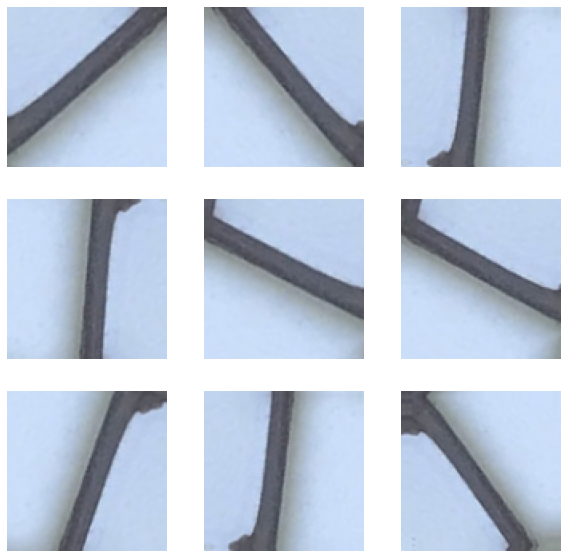

In [18]:
# Aumento de dados
# como o dataset de imagens é bem pequeno, vamos aplicar
# técnicas como zoom, espelhar e rotacionar as imagens
# existentes, criando cópias com essas modificações
# para serem inclusas no treinamento
data_augmentation = Sequential([
    RandomFlip("horizontal_and_vertical", input_shape=(img_height, img_width, 3)),
    RandomRotation(0.1),
    RandomZoom(0.1)
])

# Visualização das imagens com modificações
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")


In [19]:
# Criação do modelo
num_classes = 6
model = Sequential([
    data_augmentation,
    Rescaling(1./255),
    Conv2D(16, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(32, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(64, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Dropout(0.2),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(num_classes)
])

In [20]:
# Compilar o modelo
model.compile(
    optimizer='adam',
    loss=SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

# Exibir resumo do modelo
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_2 (Sequential)   (None, 100, 100, 3)       0         
                                                                 
 rescaling_2 (Rescaling)     (None, 100, 100, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 100, 100, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 50, 50, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 50, 50, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 25, 25, 32)       0         
 2D)                                                  

In [21]:
# Treinar o modelo
epochs = 100
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
)

Epoch 1/100
96/96 [==============================] - 3s 21ms/step - loss: 1.8012 - accuracy: 0.1771 - val_loss: 1.5632 - val_accuracy: 0.1739
Epoch 2/100
96/96 [==============================] - 2s 18ms/step - loss: 1.5812 - accuracy: 0.2292 - val_loss: 1.5037 - val_accuracy: 0.3043
Epoch 3/100
96/96 [==============================] - 2s 18ms/step - loss: 1.5753 - accuracy: 0.3021 - val_loss: 1.7942 - val_accuracy: 0.1304
Epoch 4/100
96/96 [==============================] - 2s 18ms/step - loss: 1.4261 - accuracy: 0.3438 - val_loss: 1.2456 - val_accuracy: 0.3478
Epoch 5/100
96/96 [==============================] - 2s 18ms/step - loss: 1.3934 - accuracy: 0.4167 - val_loss: 1.3807 - val_accuracy: 0.3478
Epoch 6/100
96/96 [==============================] - 2s 19ms/step - loss: 1.4371 - accuracy: 0.3750 - val_loss: 1.2009 - val_accuracy: 0.4783
Epoch 7/100
96/96 [==============================] - 2s 19ms/step - loss: 1.3465 - accuracy: 0.4062 - val_loss: 1.2141 - val_accuracy: 0.4348
Epoch 

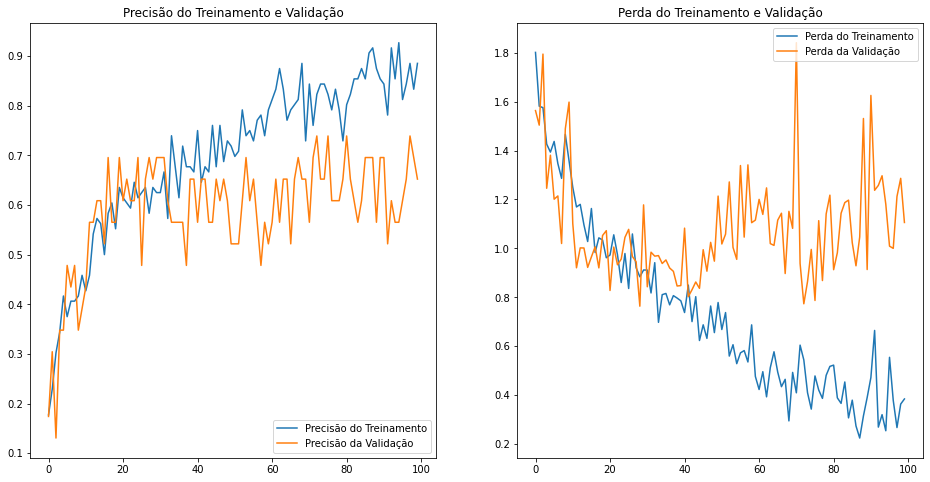

In [22]:
# Estatisticas sobre o treinamento e validação
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

# Plotar gráficos de precisão e perda
plt.figure( figsize=(16, 8) )
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Precisão do Treinamento')
plt.plot(epochs_range, val_acc, label='Precisão da Validação')
plt.legend(loc='lower right')
plt.title('Precisão do Treinamento e Validação')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Perda do Treinamento')
plt.plot(epochs_range, val_loss, label='Perda da Validação')
plt.legend(loc='upper right')
plt.title('Perda do Treinamento e Validação')
plt.show()

In [23]:
# Testar a ML
testPath = Path(photosPath, 'testes' )
img = tf.keras.utils.load_img(
    Path(testPath, 'Caule10LL.jpg' ), target_size=(img_width, img_height)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)

predictions = model.predict(img_array)
score = tf.nn.softmax( predictions[0] )
print( f"Essa imagem provavelmente pertence à classe '{ class_names[ np.argmax(score) ] }' com uma confiança de {(100 * np.max(score)):.2f}%" )

Essa imagem provavelmente pertence à classe 'leucaena_leucocephala' com uma confiança de 92.42%


In [15]:
# Exportar o modelo
MODELS_PATH = Path( rootPath, 'models' )
MODEL_PATH = Path( MODELS_PATH, 'caule.h5' )

model.save( MODEL_PATH )